In [1]:
#from structure_and_load import load
import matplotlib.pyplot as plt 
import numpy as np
import pandas as pd
import scipy.ndimage as spn 
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.pipeline import make_pipeline

from open_data  import matlab_file
from structure_data import  manage
from measures import ISI, FiringRate, tools
from classify import HistGrad

import re
import neo 
from neo.core import Event
from quantities import s 
from quantities import millisecond as ms


import os
import sys

%load_ext autoreload
%autoreload 2

# Load and format data

### Load data

In [2]:
#Load
session, data_path, info_path = matlab_file.from_lab(lab_desktop=False, session='t150204001')
data, load_info = matlab_file.open(data_path)
session_info_raw = matlab_file.clean(info_path)


43 files loaded


In [3]:
# get sessions and units information (unit, prob, elitrials)
info_units,  info_session = manage.info(load_info, session_info_raw, session)
unit_label, unit_labelProbe1, unit_labelProbe2, count_unitProbe = manage.units_label(info_units)
# manage elitrials format
info_session['elitrials'] = info_session['elitrials'].apply(manage.elitrials)
# get unit's index without eli trials 
completeUnit = manage.CompleteTasktime(info_session, load_info, session)
unit_label[:5]

Complete unit found ! 
loading index = 32
matfile : t150204001_probe1_contact3_unit1.mat


['P1-6-1', 'P2-24-1', 'P1-19-1', 'P1-17-1', 'P1-12-1']

In [4]:
spike_times, task_times, target_info = matlab_file.extract_data(\
        load_info, data, target_keys_OFF=['SC1_dir', 'SC2_dir', 'SC3_dir', 'Trial_type'],\
        target_keys_ON=['SC1_dir', 'SC2_dir', 'SC3_dir', 'Trial_type'], \
        event_keys_OFF=['Sel_OFF', 'SC1_OFF', 'SC2_OFF', 'SC3_OFF'])

In [18]:
# get trials indices per condition
target_1 = np.where(target_info[completeUnit][1]['Trial_type'] == 1)[0]
target_2 = np.where(target_info[completeUnit][1]['Trial_type'] == 2)[0]
target_3 = np.where(target_info[completeUnit][1]['Trial_type'] == 3)[0]

In [5]:
indices = np.arange(0,completeUnit+1, 4)
indices

array([ 0,  4,  8, 12, 16, 20, 24, 28, 32])

In [6]:
spike_times = [spike_times[i] for i in indices]

In [7]:
len(spike_times)

9

### Format spike times 

In [8]:
len(task_times)

43

In [9]:
event_labels = matlab_file.get_event_labels(task_times)
event_times = matlab_file.get_event_times(task_times, event_labels)
# reshape times by trials / periods for each neuron + Neo format
trials_ts, df_task_ts_by_neuron, events = manage.events_by_trial(event_times, event_labels)

In [10]:
unit_ = 32
trial_ = 12
print(f'times as list : {trials_ts[unit_][1][trial_]}')
print(f'times as neo events : {events[unit_][1][trial_].times}')
print(f'spike train sample : {spike_times[0][1]}\nevents : {event_labels}\ntargets : {task_times[0][1].keys()}')


times as list : [354096 355172 356491 357799 359134 360433 361087]
times as neo events : [354096. 355172. 356491. 357799. 359134. 360433. 361087.] ms
spike train sample : [    334    5067    6996 ... 3658225 3659812 3660582]
events : ['Touch_time', 'Sel_ON', 'SC1_ON', 'SC2_ON', 'SC3_ON', 'Go_time', 'Target_time']
targets : dict_keys(['Touch_time', 'Sel_ON', 'SC1_ON', 'SC2_ON', 'SC3_ON', 'Go_time', 'Target_time'])


In [48]:
# get dataframe with each events times per trials for a complete session
tot_trials_in_task = trials_ts[completeUnit][1].shape[0]
df_task_ts = pd.DataFrame(trials_ts[completeUnit][1], columns=event_labels, index=np.arange(0, tot_trials_in_task))
df_task_ts.tail()

event_vector = df_task_ts.loc[0].values - df_task_ts.loc[0].values[0]
target_list = ['trial_type', 'position']
measures_list = ['FR', 'Synch', 'ISI']

### Format target

In [12]:
target = manage.target_by_trials(target_info, completeUnit)
target

,trial_type,position,type_and_pos
0,1,2,0
1,1,2,0
2,1,3,1
3,1,3,1
4,1,4,2
...,...,...,...
171,1,3,1
172,2,3,4
173,2,4,5
174,2,4,5


### Format trials

In [13]:
# align times by trials for each neurons
df_task_ts_by_neuron = manage.time_by_trials(df_task_ts_by_neuron, df_task_ts, event_labels)

# split the spike time vector by trial
spk_trials, spike_train_trial = manage.spike_ts_by_trial(trials_ts, spike_times)
spikes_times_aligned = manage.spike_ts_aligned(df_task_ts, df_task_ts_by_neuron, spike_times, unit_label, spike_train_trial)

# Raster plot

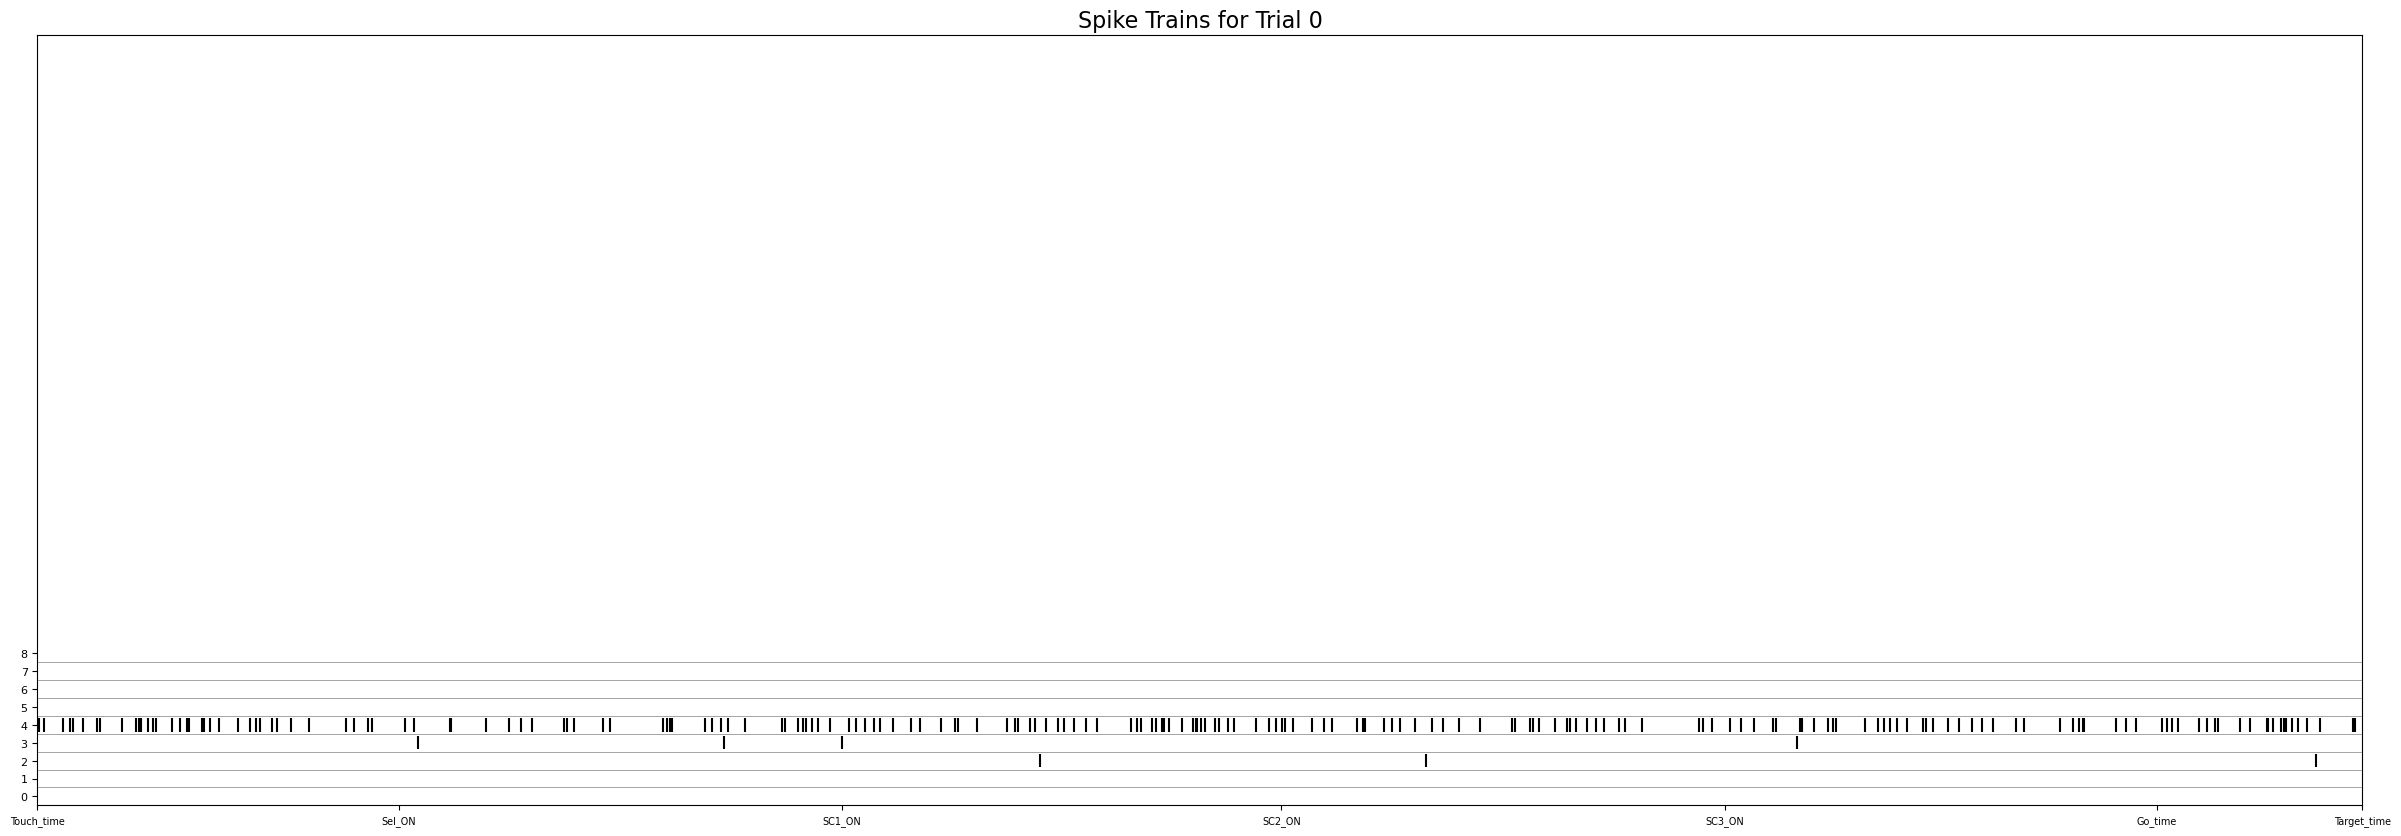

In [14]:
n_neurons = spikes_times_aligned.shape[0]

t = 0
event_vector = df_task_ts.loc[t]

plt.figure(figsize=(30, 10))  # Ajustez la taille de la figure selon vos besoins

# Parcourir tous les neurones et tracer leur spike train
for n in range(n_neurons): 
    spiketrain = spikes_times_aligned[n][t]['spike_train']
    if len(spiketrain) > 0 and spiketrain[0] != 0:      
        plt.eventplot(spiketrain.magnitude, linelengths=0.75, lineoffsets=n, color='black')
for i in range(n_neurons - 1):
    plt.hlines(i+0.5, xmin=event_vector.min(), xmax=event_vector.max(), colors='gray', linestyles='solid', linewidth=0.5)

# Définir les étiquettes de l'axe x et l'axe y
plt.xticks(event_vector.values, event_labels, fontsize=7)
plt.yticks(range(n_neurons), [f"{i}" for i in range(n_neurons)], fontsize=8)
plt.title(f"Spike Trains for Trial {t}", fontsize=16)

# Ajuster les limites des axes
plt.xlim(event_vector.min(), event_vector.max())
plt.ylim(-0.5, 42.5)

plt.show()


# Compute measure

## Instantaneous Firing rate 

In [15]:
sigma = [100]

max_length = tools.get_max_length_trials(spikes_times_aligned[-1])
spikes_binarized = FiringRate.binarize_spike_times(spikes_times_aligned, max_length)
spike_convolved = FiringRate.convolve_spike_binarized(spikes_binarized, sigma)

In [17]:
spike_convolved.shape

(176, 7304, 9)

## Paiwise synchrony

In [20]:
row, col = np.triu_indices(n_neurons, k=1)
n_pairs = len(row)
list_pairs = np.zeros((n_pairs,3), dtype='int')

for n_p, (r,c) in enumerate(zip(row, col)):
    list_pairs[n_p, 0] =  r
    list_pairs[n_p, 1] =  c
    list_pairs[n_p, 2] =  n_p

In [21]:
n_trials, n_times, n_neurons = spike_convolved.shape
Synch = np.zeros((n_trials, n_times, n_pairs))


for t in range(n_trials) :     
    for n_p, (r,c) in enumerate(zip(row, col)):
        Synch[t,:,n_p] = spike_convolved[t, :, r] * spike_convolved[t, :, c]

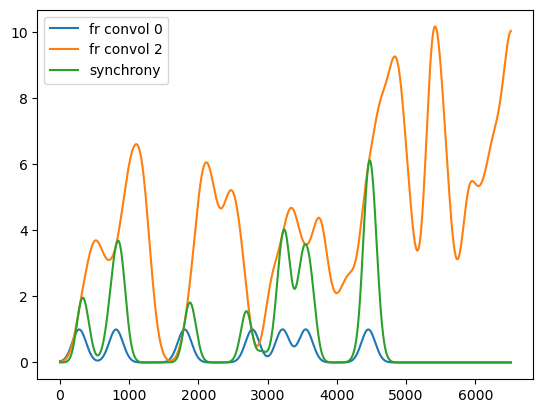

In [22]:
n0 = 0
n1 = 2
neurons_ = [n0,n1]
pair = list_pairs[np.logical_and(list_pairs[:,0] == n0, list_pairs[:,1] == n1)][0][2]
plt.plot(spike_convolved[121,:,n0], label=f'fr convol {n0}')
plt.plot(spike_convolved[121,:,n1], label=f'fr convol {n1}')
plt.plot(Synch[121,:,pair], label='synchrony')
plt.legend()

## ISI Distance

In [23]:
X_isi_ = np.zeros((n_trials), dtype=object)
ISI_distance = []
X_isi = []

for t in range(n_trials) : 
    n_times = spikes_times_aligned[0][t]['t_stop_aligned']
    X_isi_one_trial = np.zeros((n_neurons, n_times))
    for n in range(n_neurons) :
        x_isi = ISI.compute(spikes_times_aligned[n][t]) 
        X_isi_one_trial[n, :] = x_isi

    ISI_distance_one_trials = np.zeros((n_pairs, n_times))
    for n_p, (r,c) in enumerate(zip(row, col)):
        ISI_distance_one_trials[n_p,:] = ISI.distance(X_isi_one_trial[r, :], X_isi_one_trial[c, :])
    
    X_isi.append(X_isi_one_trial)
    ISI_distance.append(ISI_distance_one_trials)

In [24]:
max_length, time = tools.get_max_length_ISI(n_trials, ISI_distance)
ISI_distance_interp = np.zeros((n_trials, max_length, n_pairs), dtype=np.float32)
X_isi_interp = np.zeros((n_trials, max_length, n_neurons), dtype=np.float32)


for t in range(n_trials):
        for p in range(n_pairs):
                ISI_distance_interp[t, :, p]  = ISI.interpolate_ISI_distance(ISI_distance[t][p], max_length)
        for n in range(n_neurons) : 
                X_isi_interp[t, :, n] = ISI.interpolate_X_isi(X_isi[t][n], max_length)
        

# Plot measure

7304
(176, 7304, 9)
(176, 7304, 9)


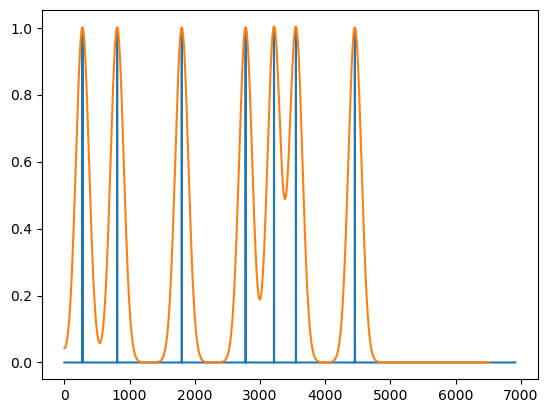

In [25]:
print(max_length)
print(spikes_binarized.shape)
print(spike_convolved.shape)
plt.plot(spikes_binarized[121,:,0])
plt.plot(spike_convolved[121,:,0])

(-500.0, 7804.0)

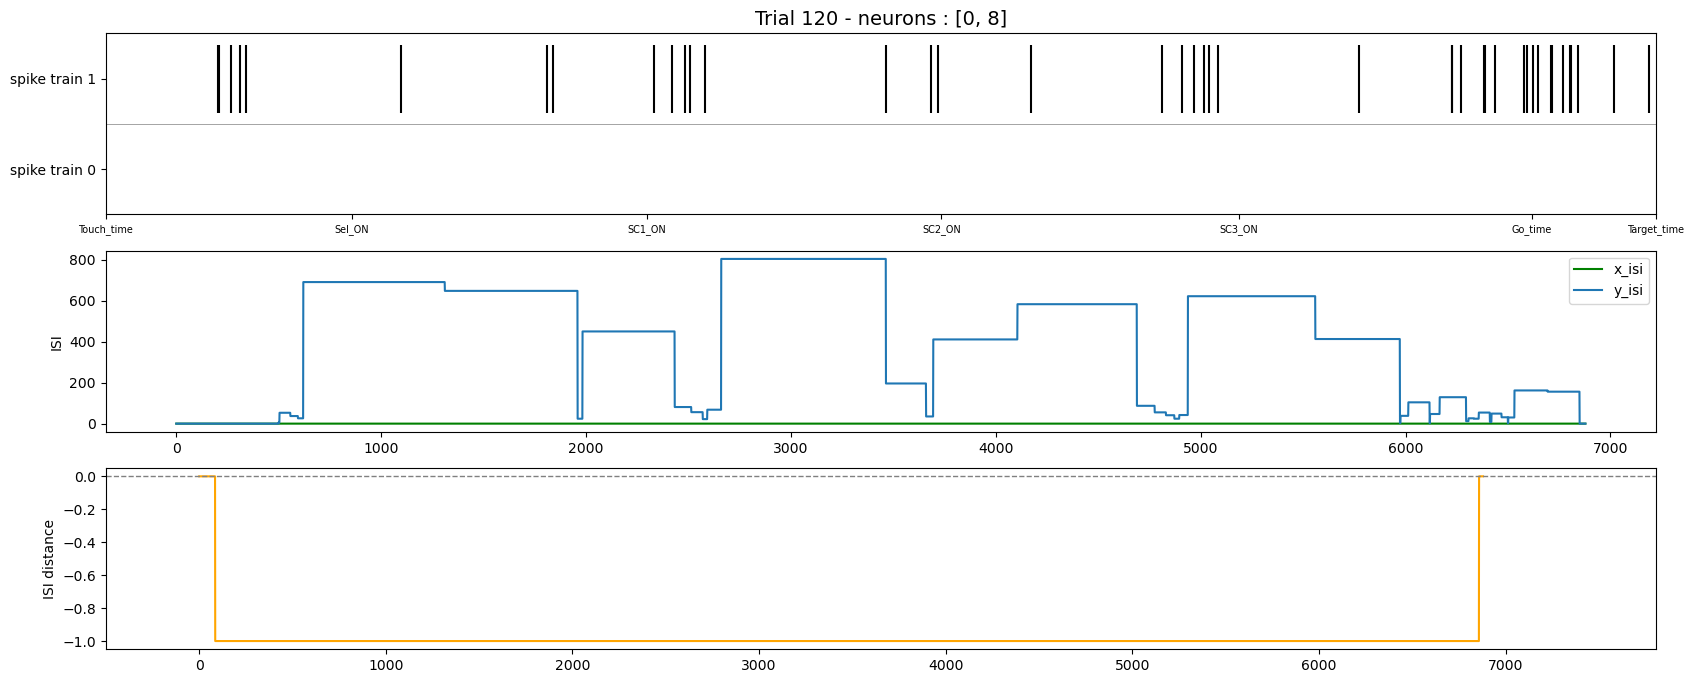

In [26]:
t = 120
neurons_ = [0,8]
event_vector = df_task_ts.loc[t]

fig, axs = plt.subplots(3,1, figsize=(20, 8))
# Parcourir tous les neurones et tracer leur spike train
for idx, n in enumerate(neurons_) :
    spiketrain = spikes_times_aligned[n][t]['spike_train']

    if len(spiketrain) > 0 and spiketrain[0] != 0:      
        axs[0].eventplot(spiketrain.magnitude, linelengths=0.75, lineoffsets=idx, color='black')
for i in range(len(neurons_) - 1):
    axs[0].hlines(i+0.5, xmin=event_vector.min(), xmax=event_vector.max(), colors='gray', linestyles='solid', linewidth=0.5)

# Définir les étiquettes de l'axe x et l'axe y
axs[0].set_xticks(event_vector.values)
axs[0].set_xticklabels(event_labels, fontsize=7)
axs[0].set_yticks(range(n_neurons))
axs[0].set_yticklabels([f"spike train {n}" for n in range(n_neurons)], fontsize=10)
axs[0].set_title(f"Trial {t} - neurons : {neurons_}", fontsize=14)

# Ajuster les limites des axes
axs[0].set_xlim(event_vector.min(), event_vector.max())
axs[0].set_ylim(-0.5, len(neurons_)-0.5)


x_isi_in_time = ISI.compute(spikes_times_aligned[neurons_[0]][t])
y_isi_in_time = ISI.compute(spikes_times_aligned[neurons_[1]][t]) 
ISI_distance_ = ISI.distance(x_isi_in_time, y_isi_in_time)


# Create a figure with two subplots
# Plot x_isi and y_isi in the first column
axs[1].plot(x_isi_in_time, color = 'green', label='x_isi')
axs[1].plot(y_isi_in_time, label='y_isi')
axs[1].set_ylabel('ISI', fontsize=10)
axs[1].legend()
0
# Plot isi_dist in the second column
axs[2].plot(ISI_distance_interp[t,:,0], color='orange')
axs[2].set_ylabel('ISI distance', fontsize=10)
axs[2].hlines(0, xmin=-500, xmax=ISI_distance_interp[t,:,0].shape[0]+ 500, colors='gray', linestyles='dashed', linewidth=1)
axs[2].set_xlim(-500, ISI_distance_interp[t,:,0].shape[0] + 500)  # Set x-axis limits



In [30]:
spike_convolved.shape

(176, 7304, 9)

In [35]:
X_ISI_mean = []
FR_mean = []
I_mean = []
Synch_mean = []

targets_labels = [target_1, target_2, target_3]

for target in targets_labels:
    X_ISI_mean.append(np.nanmean(X_isi_interp[target, :, :], axis=(0, 2)))
    FR_mean.append(np.nanmean(spike_convolved[target, :, :], axis=(0, 2)))
    I_mean.append(np.nanmean(ISI_distance_interp[target], axis=(0, 2)))
    Synch_mean.append(np.nanmean(Synch[target, :,:], axis=(0, 2)))

/tmp/ipykernel_7735/2577517711.py:9: RuntimeWarning: Mean of empty slice
  X_ISI_mean.append(np.nanmean(X_isi_interp[target, :, :], axis=(0, 2)))
/tmp/ipykernel_7735/2577517711.py:10: RuntimeWarning: Mean of empty slice
  FR_mean.append(np.nanmean(spike_convolved[target, :, :], axis=(0, 2)))
/tmp/ipykernel_7735/2577517711.py:11: RuntimeWarning: Mean of empty slice
  I_mean.append(np.nanmean(ISI_distance_interp[target], axis=(0, 2)))
/tmp/ipykernel_7735/2577517711.py:12: RuntimeWarning: Mean of empty slice
  Synch_mean.append(np.nanmean(Synch[target, :,:], axis=(0, 2)))


In [42]:
FR_mean[0].shape

(7304,)

In [43]:
FR_mean[1].shape

(7304,)

In [58]:
event_labels = ['Touch', 'Selection Cue', 'Spatial Cue1', 'Spatial Cue2', 'Spatial Cue 3', 'Go', 'Target']

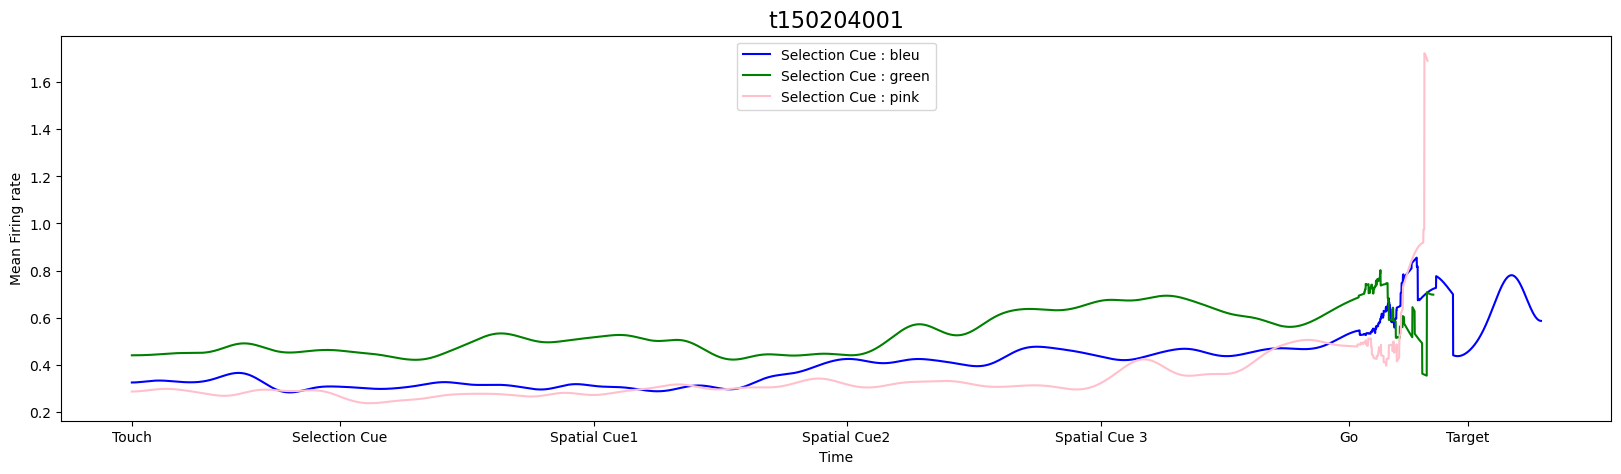

In [59]:
colors = ['blue', 'green', 'pink']  # Liste de couleurs pour chaque tracé
plt.figure(figsize=(20,5))

for idx, trg in enumerate(targets_labels):
    plt.plot(FR_mean[idx], color=colors[idx]) 
    plt.xticks(event_vector, event_labels)
    plt.ylabel('Mean Firing rate')
plt.title(f'{session}', fontsize=16)
plt.legend(('Selection Cue : bleu', 'Selection Cue : green', 'Selection Cue : pink'),
           loc='upper center')

# Classif 

In [ ]:
n_times = list(np.arange(0, ISI_distance_interp.shape[1], 100))
n_bins = len(n_times)

# Initialiser une liste vide pour stocker les moyennes de bin
list_mean = {'FR'  : [],
            'Synch' : [],
            'ISI': []}

list_data = {'FR' : spike_convolved,
            'Synch': Synch,
            'ISI': ISI_distance_interp}

# Calculer la moyenne sur l'axe des temps
for key, data in list_data.items():
    # Calculer les moyennes pour chaque bin et chaque paire
    for start, end in zip(n_times[:-1], n_times[1:]):
        # Extraire les données pour le bin actuel
        bin_data = data[:, start:end, :]
        # Calculer la moyenne sur l'axe des temps
        bin_mean = np.nanmean(bin_data, axis=1)
        # Convertir les moyennes en DataFrame et les ajouter à la liste
        bin_mean_df = pd.DataFrame(bin_mean)
        list_mean[key].append(bin_mean_df)

/tmp/ipykernel_29229/3758335856.py:20: RuntimeWarning: Mean of empty slice
  bin_mean = np.nanmean(bin_data, axis=1)


In [ ]:
# Build pipeline
n_splits = 5
# Cross-validation scheme
cvs0 = StratifiedShuffleSplit(n_splits=n_splits, test_size=0.2)
# Standardisation scheme
scaler = StandardScaler()
# Algo
estimator = HistGradientBoostingClassifier(max_iter=5, max_depth=10, max_bins=10)
clf = make_pipeline(scaler, estimator)

In [ ]:
list_models = {'FR'  : [],
            'Synch' : [],
            'ISI': []}
for key, data in list_mean.items():
    for idx, t in enumerate(n_times[:-1]):
        model = HistGrad.Model_info(n_splits=n_splits, n_events=n_bins, \
        data=data[idx], cvs=cvs0, clf=clf)
        
        list_models[key].append(model)

In [ ]:
acc_df = HistGrad.run_classif_confusion(list_models, target, n_times)

#################
SPLIT : 0
##################
FR


/home/laurie/anaconda3/envs/env_classif/lib/python3.11/site-packages/sklearn/utils/extmath.py:1051: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/home/laurie/anaconda3/envs/env_classif/lib/python3.11/site-packages/sklearn/utils/extmath.py:1056: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
/home/laurie/anaconda3/envs/env_classif/lib/python3.11/site-packages/sklearn/utils/extmath.py:1076: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
/home/laurie/anaconda3/envs/env_classif/lib/python3.11/site-packages/sklearn/utils/extmath.py:1051: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/home/laurie/anaconda3/envs/env_classif/lib/python3.11/site-packages/sklearn/utils/extmath.py:1056: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_s

Synch


/home/laurie/anaconda3/envs/env_classif/lib/python3.11/site-packages/sklearn/utils/extmath.py:1051: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/home/laurie/anaconda3/envs/env_classif/lib/python3.11/site-packages/sklearn/utils/extmath.py:1056: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
/home/laurie/anaconda3/envs/env_classif/lib/python3.11/site-packages/sklearn/utils/extmath.py:1076: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
/home/laurie/anaconda3/envs/env_classif/lib/python3.11/site-packages/sklearn/utils/extmath.py:1051: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/home/laurie/anaconda3/envs/env_classif/lib/python3.11/site-packages/sklearn/utils/extmath.py:1056: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_s

ISI
#################
SPLIT : 1
##################
FR
Synch
ISI


In [ ]:
# Définir le style de seaborn
sns.set(style="whitegrid")
plt.rcParams["axes.labelweight"] = "bold"
plt.rcParams["axes.labelsize"] = 14
plt.rcParams["axes.labelpad"] = 12
plt.rcParams["xtick.labelsize"] = 12  
plt.rcParams["ytick.labelsize"] = 12 

palette = ['#006d2c', '#54278f', '#4292c6']
color_shuff = '#969696'

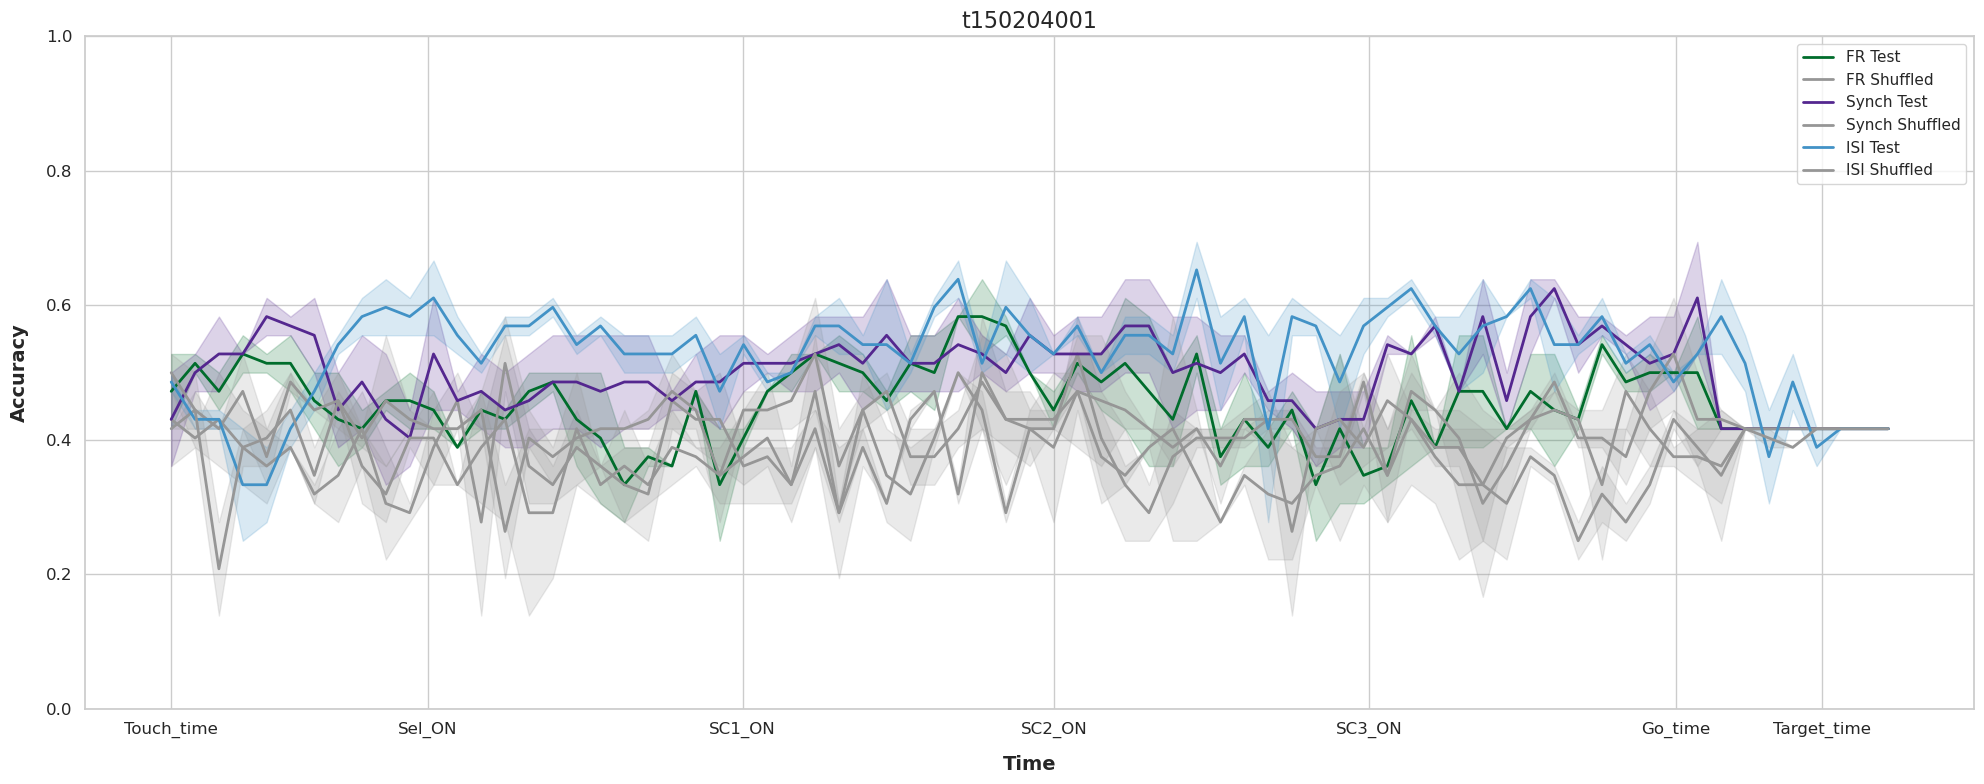

In [ ]:
fig, ax = plt.subplots(figsize=(20, 8), dpi=100)  

for i, measure in enumerate(measures_list):

    accuracy_plot = acc_df[(acc_df['measure'] == measure) & (acc_df['target_type'] == target_list[0]) ]
    
    accuracy_plot_test = accuracy_plot[accuracy_plot["data_type"] == 'test']
    sns.lineplot(accuracy_plot_test, x='time', y='accuracy', color=palette[i], linewidth=2., ax=ax, label=f'{measure} Test')


    accuracy_plot_shuff = accuracy_plot[accuracy_plot["data_type"] == 'shuff']
    sns.lineplot(accuracy_plot_shuff, x='time', y='accuracy', color=color_shuff, linewidth=2., ax=ax, label=f'{measure} Shuffled')

ax.set_xticks(event_vector)
ax.set_xticklabels(event_labels)
ax.set_yticks(np.arange(0, 1.1, 0.2))
ax.set_xlabel('Time')
ax.set_ylabel('Accuracy')
plt.title(f'{session}', fontsize=16)
plt.legend()
plt.tight_layout()
#plt.savefig(f'/home/INT/mifsud.l/Bureau/presentation/LaminarClub/HistGrad_{session}_position.png')
plt.show()


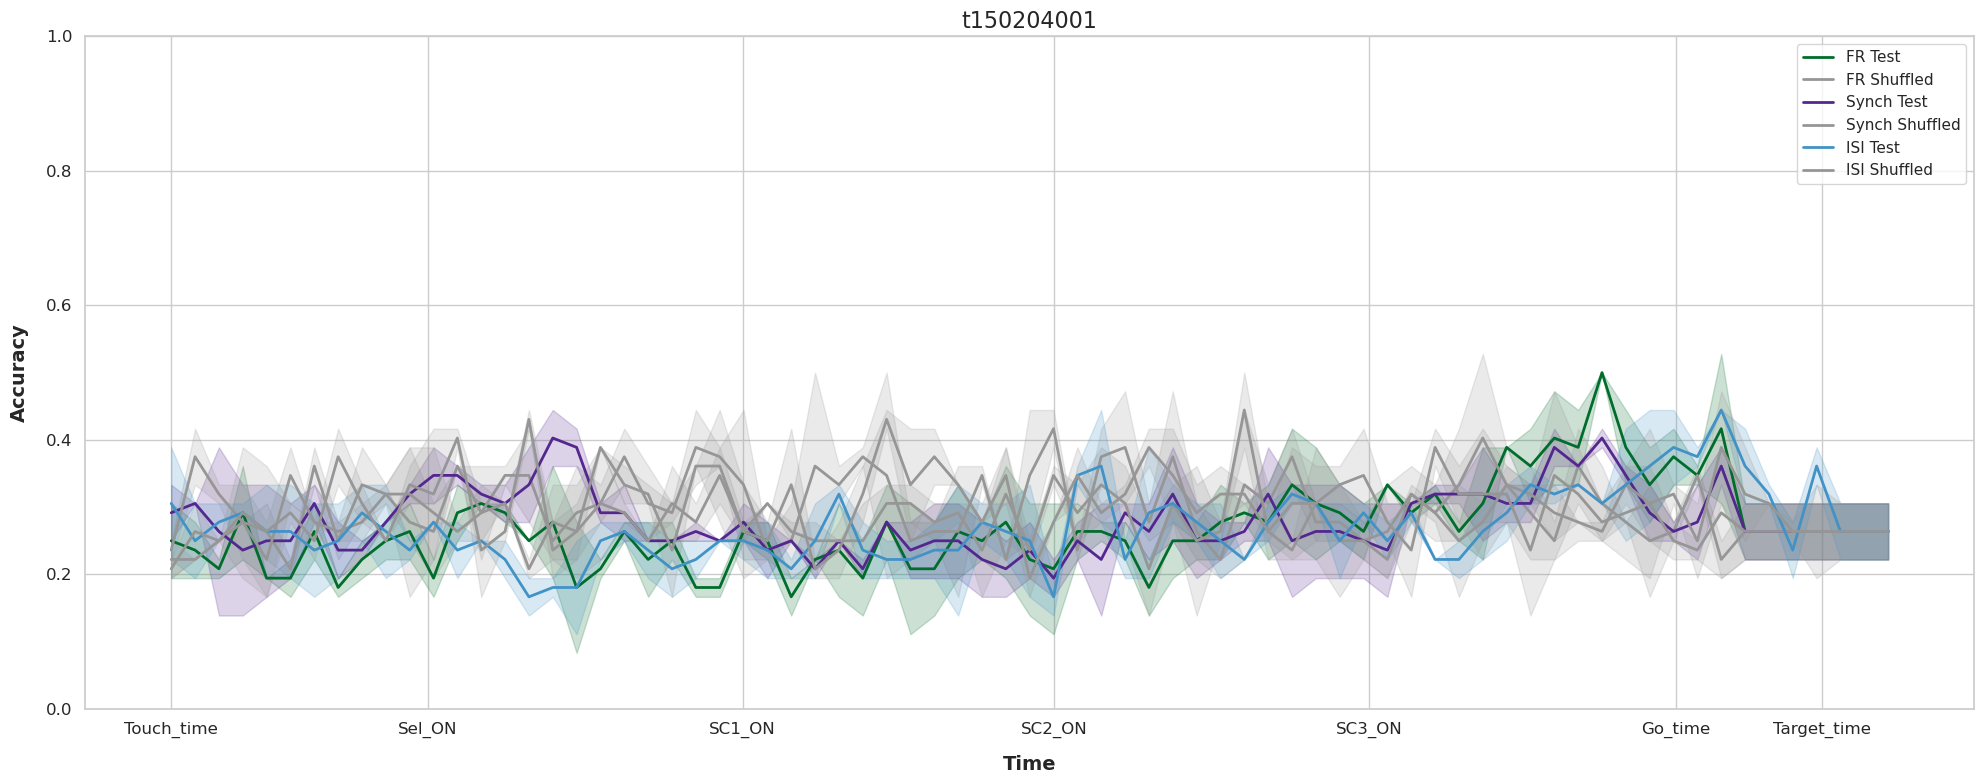

In [ ]:
fig, ax = plt.subplots(figsize=(20, 8), dpi=100)  

for i, measure in enumerate(measures_list):

    accuracy_plot = acc_df[(acc_df['measure'] == measure) & (acc_df['target_type'] == target_list[1]) ]
    
    accuracy_plot_test = accuracy_plot[accuracy_plot["data_type"] == 'test']
    sns.lineplot(accuracy_plot_test, x='time', y='accuracy', color=palette[i], linewidth=2., ax=ax, label=f'{measure} Test')


    accuracy_plot_shuff = accuracy_plot[accuracy_plot["data_type"] == 'shuff']
    sns.lineplot(accuracy_plot_shuff, x='time', y='accuracy', color=color_shuff, linewidth=2., ax=ax, label=f'{measure} Shuffled')

ax.set_xticks(event_vector)
ax.set_xticklabels(event_labels)
ax.set_yticks(np.arange(0, 1.1, 0.2))
ax.set_xlabel('Time')
ax.set_ylabel('Accuracy')
plt.title(f'{session}', fontsize=16)
plt.legend()
plt.tight_layout()
#plt.savefig(f'/home/INT/mifsud.l/Bureau/presentation/LaminarClub/HistGrad_{session}_position.png')
plt.show()

In [ ]:
time = acc_df['time'].unique()
time_list = []
time_list.append(time[0:11])
time_list.append(time[11:24])
time_list.append(time[24:38])
time_list.append(time[38:52])
time_list.append(time[52:72])
time_list.append(time[72])

In [ ]:
# Extract confusion matrices
acc_df_test = acc_df[acc_df['data_type'] == 'test']
acc_df_test_trial_type = acc_df_test[acc_df_test['target_type'] == 'trial_type']

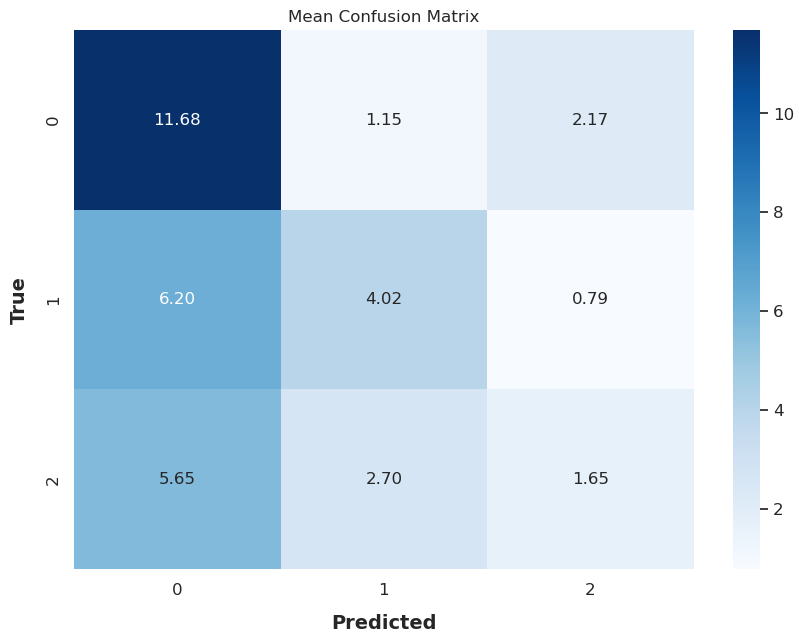

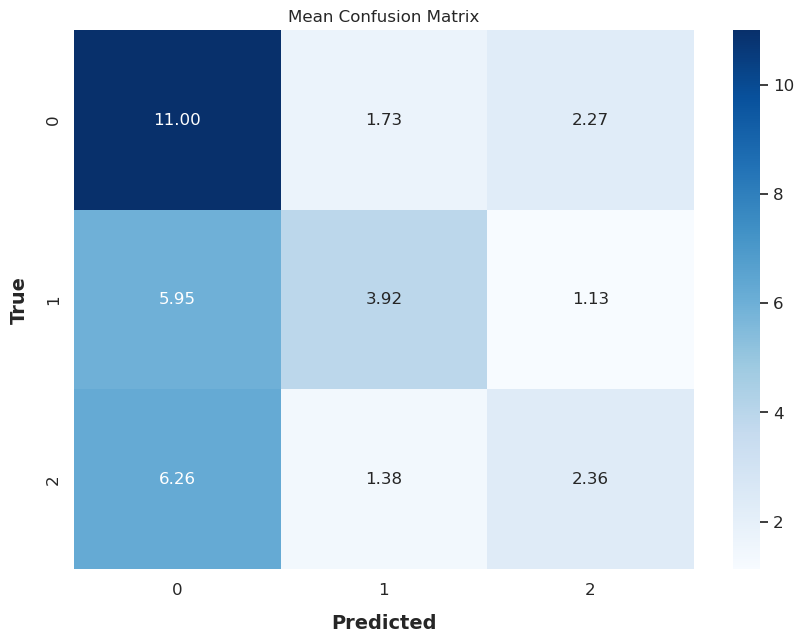

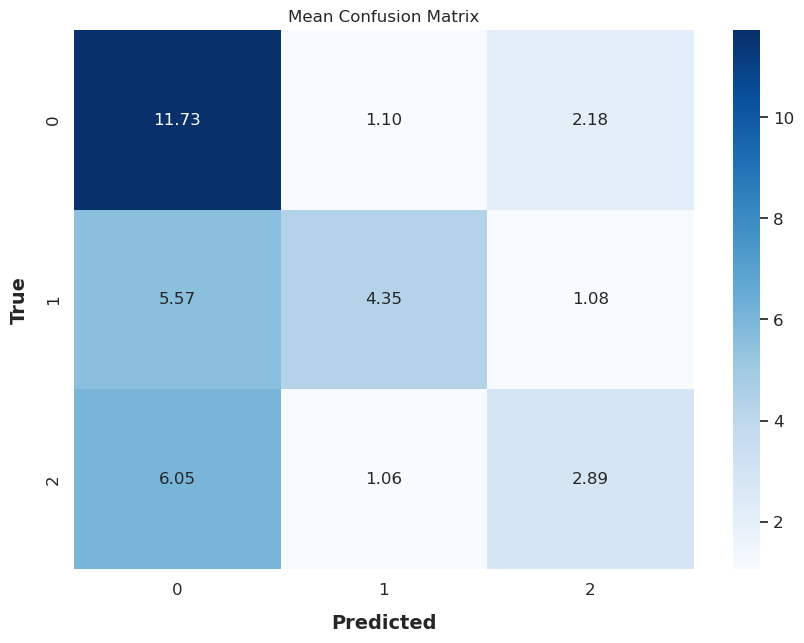

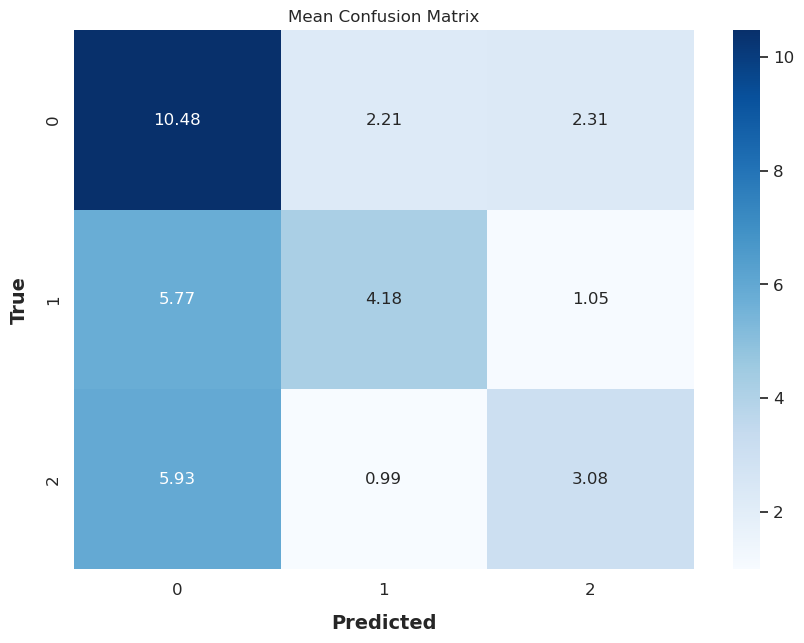

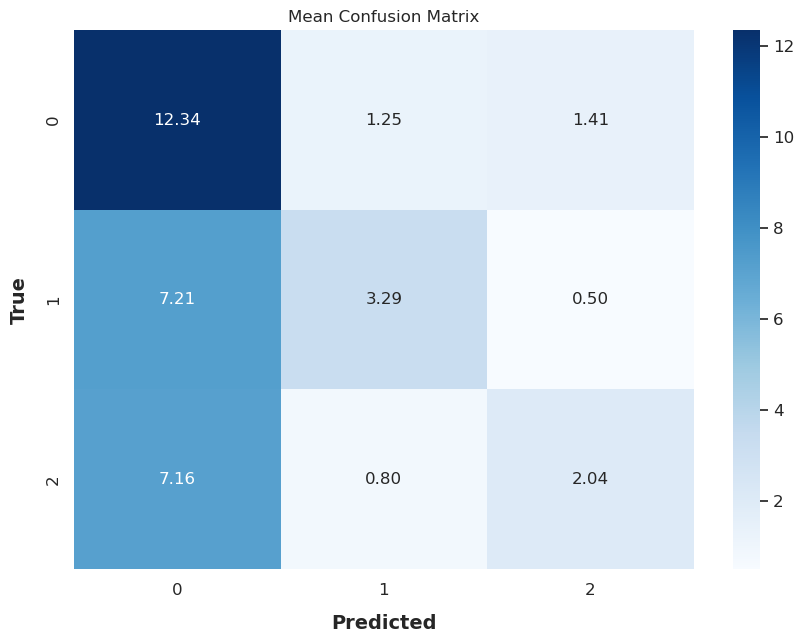

In [ ]:
for i in range(len(time_list) - 1): 
    acc_plot = acc_df_test_trial_type[acc_df_test_trial_type['time'].isin(time_list[i])]['confusion_matrix']
    mean_conf_matrix = np.mean(acc_plot.to_list(), axis=0)
    # Plot the mean confusion matrix
    plt.figure(figsize=(10, 7))
    sns.heatmap(mean_conf_matrix, annot=True, fmt=".2f", cmap="Blues")
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Mean Confusion Matrix')
    plt.show()

In [ ]:
acc_plot = acc_df_test_trial_type[acc_df_test_trial_type['time'] == time_list[-1]]['confusion_matrix']
mean_conf_matrix = np.mean(acc_plot.to_list(), axis=0)
mean_conf_matrix

array([[15.,  0.,  0.],
       [11.,  0.,  0.],
       [10.,  0.,  0.]])

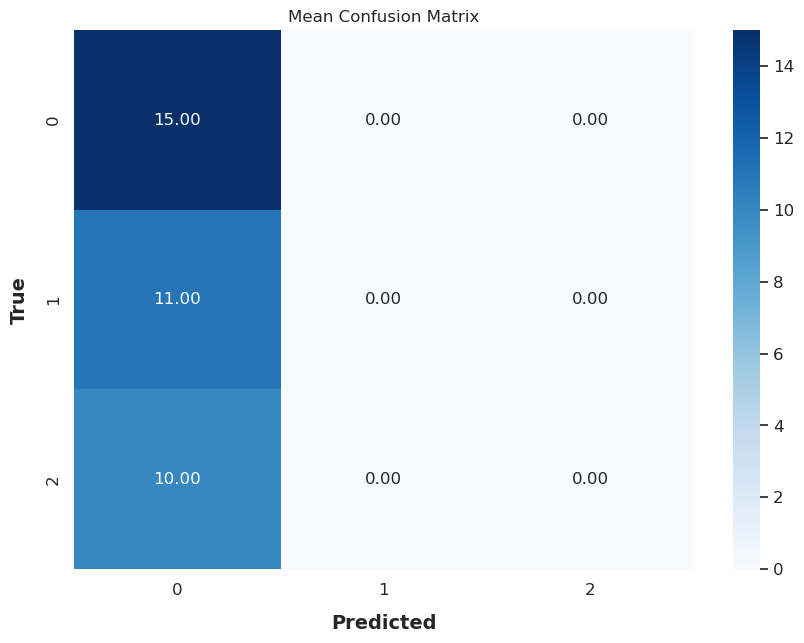

In [ ]:
# Plot the mean confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(mean_conf_matrix, annot=True, fmt=".2f", cmap="Blues")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Mean Confusion Matrix')
plt.show()